# Dubins Car Path Planning

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
print(shutil.which("ipopt"))

Running Python: 3.9.9
/usr/local/bin/ipopt


## Problem Statement

Simplified dynamics of a UAV flying in a horizontal plane can be
modeled as:
$$ \left.
\begin{array}{l}
    \dot{x}(t)  =  V\cos \theta(t) \\
    \dot{y}(t)  =  V\sin \theta(t) \\
    \dot{\theta}(t)  =  \omega(t) 
\end{array} \right\} \quad \dot {\bf x} = \mathbf{f}(\mathbf{x},\mathbf{u})
$$
where $\theta(t)$ is heading angle wrt $x$
axis, $V$ is speed, and $u(t) = \omega(t)$ control input.

**Objective**: fly from point A to B in (nearly) minimum time:
$$
    \min J = \int_{0}^{t_f} (1+\alpha u(t) ^2) dt
$$
where $\alpha$ is suitable weighting factor ($\ll 1$) and
$t_f$ is free

Initial conditions are: $x(0) = x_0, y(0) = y_0, \theta(0) = \theta_0 $
and final conditions are $x(t_f) = x_1, y(t_f) = y_1, \theta(t_f) = \theta_1 $

Define Hamiltonian
\begin{eqnarray}
H &=& g +\mathbf{p}(t)^T \mathbf{f} \\
&=& (1+\alpha u^2) + p_1 (V\cos \theta(t))+ p_2 (V\sin \theta(t)) + p_3 (u)
\end{eqnarray}

With state $\mathbf{x} = \left[\begin{array}{ccc} x & y & \theta \end{array} \right]^T$, necessary conditions give 
\begin{eqnarray}
\mathbf{\dot x} &=& \mathbf{f}(\mathbf{x},\mathbf{u},t) \\
\mathbf{\dot p} &=& -H_\mathbf{x}^T \\
H_\mathbf{u} &=& 0 \\[1em]
\dot{p_1}(t) & = & 0\\
\dot{p_2}(t) & = & 0\\
\dot{p_3}(t) & = & p_1 V\sin \theta(t) - p_2 V\cos \theta(t)\\
2 \alpha u + p_3 &=&0
\end{eqnarray}


## Solve by satisfying the necessary conditions (see 6-10)

In [2]:
# parameters
alp = 0.5
V = 1.25
X1 = 2 # Terminal State - X0 = 0 
Y1 = 2 # Terminal State - Y0 = 0
TH0 = np.pi*(120/180) # Initial angle
TH1 = np.pi*(225/180) # Final angle
tf_estimate = sqrt((X1-0)**2+(Y1-0)**2)/V

In [3]:
# create a model object
m = ConcreteModel()

# define the independent variable
m.tf = Var(domain=NonNegativeReals, initialize = tf_estimate)
m.t = ContinuousSet(bounds=(0, 1))

# define the dependent variables
m.x = Var(m.t, initialize = 0)
m.y = Var(m.t, initialize = 0)
m.th = Var(m.t, initialize = TH0)
m.p1 = Var(m.t, initialize = 1)
m.p2 = Var(m.t, initialize = 1)
m.p3 = Var(m.t, initialize = 1)

# define derivatives
m.x_dot = DerivativeVar(m.x)
m.y_dot = DerivativeVar(m.y)
m.th_dot = DerivativeVar(m.th)
m.p1_dot = DerivativeVar(m.p1)
m.p2_dot = DerivativeVar(m.p2)
m.p3_dot = DerivativeVar(m.p3)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.tf*(V*cos(m.th[t])))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.tf*(V*sin(m.th[t])))
m.ode_th = Constraint(m.t, rule=lambda m, t: m.th_dot[t] == m.tf*(-m.p3[t]/2/alp))
m.ode_p1 = Constraint(m.t, rule=lambda m, t: m.p1_dot[t] == m.tf*(0))
m.ode_p2 = Constraint(m.t, rule=lambda m, t: m.p2_dot[t] == m.tf*(0))
m.ode_p3 = Constraint(m.t, rule=lambda m, t: m.p3_dot[t] == m.tf*V*(m.p1[t]*sin(m.th[t])-m.p2[t]*cos(m.th[t])))

# initial conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==0)
m.pc.add(m.y[0]==0)
m.pc.add(m.th[0]==TH0)

# final conditions
m.pc.add(m.x[1]==X1)
m.pc.add(m.y[1]==Y1)
m.pc.add(m.th[1]==TH1)
m.pc.add(1+alp*(-m.p3[1]/2/alp)**2+m.p1[1]*V*cos(m.th[1])+m.p2[1]*V*sin(m.th[1])+m.p3[1]*(-m.p3[1]/2/alp) == 0)

# transform and solve
#TransformationFactory('dae.finite_difference').apply_to(m, nfe=200)
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m,wrt=m.t,nfe=500,ncp=3,scheme='LAGRANGE-RADAU')
solver = SolverFactory('ipopt')
#solver.options['max_iter']= 10000 #number of iterations you wish
solver.solve(m).write()
!cp test1.txt Dubins1.txt

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 18013
  Number of variables: 18013
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.5060789585113525
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


mission length = 4.66 seconds


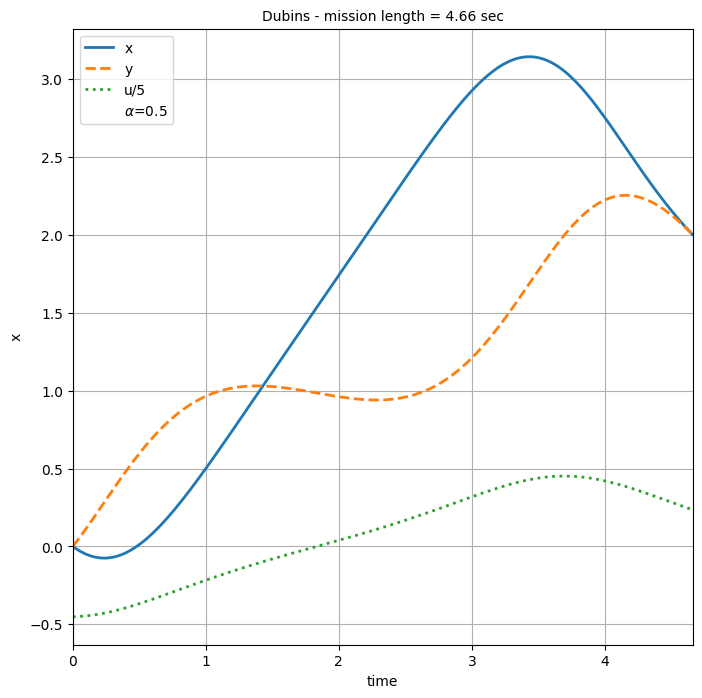

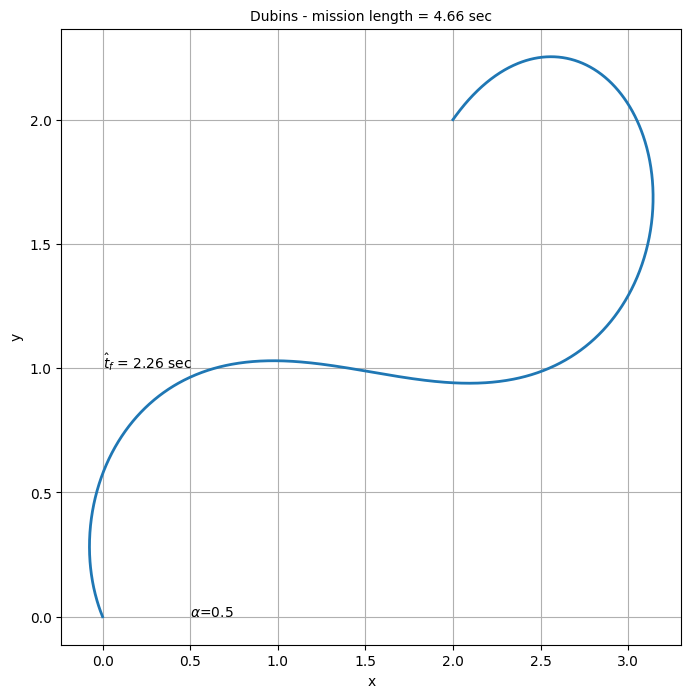

In [4]:
print('mission length = ' + str(round(m.tf(),3)) + ' seconds')

# access the results
t = np.array([t*m.tf() for t in m.t])
x = np.array([m.x[t]() for t in m.t])
y = np.array([m.y[t]() for t in m.t])
theta = np.array([m.th[t]() for t in m.t])

p1 = np.array([m.p1[t]() for t in m.t])
p2 = np.array([m.p2[t]() for t in m.t])
p3 = np.array([m.p3[t]() for t in m.t])
u = -p3/2/alp

plt.figure(1,figsize=(8,8))
plt.plot(t, x, ls='-')
plt.plot(t, y, ls='--')
plt.plot(t, u/5, ls=':')
plt.plot(np.NaN, np.NaN, '-', color='none')
plt.xlabel('time')
plt.ylabel('x')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.legend(['x','y','u/5',r'$\alpha$='+ str(round(alp,2))])
#plt.text(0.5,0,r'$\alpha$='+ str(round(alp,2)))
plt.grid(True)
plt.xlim([0,m.tf()])
plt.savefig("figs/Pyomo_Dubins11.png")

plt.figure(2,figsize=(8,8))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.grid(True)
plt.text(0,Y1/2,r'$\hat t_{f}$ = '+ str(round(tf_estimate,2))+ ' sec')
plt.text(0.5,0,r'$\alpha$='+ str(round(alp,2)))
plt.savefig("figs/Pyomo_Dubins12.png")

## Re-solve this problem as an optimization

In [5]:
# create a model object
m = ConcreteModel()

# define the independent variable
m.tf = Var(domain=NonNegativeReals, initialize = tf_estimate)
m.t = ContinuousSet(bounds=(0, 1))

# define control inputs
m.u = Var(m.t, initialize = 0.1, bounds=(-1.5,1.5))

# define the dependent variables
m.x = Var(m.t, initialize = 0)
m.y = Var(m.t, initialize = 0)
m.th = Var(m.t, initialize = TH0)

# define derivatives
m.x_dot = DerivativeVar(m.x)
m.y_dot = DerivativeVar(m.y)
m.th_dot = DerivativeVar(m.th)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.tf*(V*cos(m.th[t])))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.tf*(V*sin(m.th[t])))
m.ode_th = Constraint(m.t, rule=lambda m, t: m.th_dot[t] == m.tf*(m.u[t]))

# initial conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==0)
m.pc.add(m.y[0]==0)
m.pc.add(m.th[0]==TH0)

# final conditions
m.pc.add(m.x[1]==X1)
m.pc.add(m.y[1]==Y1)
m.pc.add(m.th[1]==TH1)

# define the optimization objective
m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.tf*(1 + alp*(m.u[t])**2))
m.obj = Objective(expr = m.integral)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=1000)
#discretizer = TransformationFactory('dae.collocation')
#discretizer.apply_to(m,wrt=m.t,nfe=500,ncp=3,scheme='LAGRANGE-RADAU')
solver = SolverFactory('ipopt')
#discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.t)
solver.options['max_iter']= 10000 #number of iterations you wish
solver.solve(m).write()
!cp test1.txt Dubins2.txt

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 6009
  Number of variables: 7008
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.3929588794708252
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


mission length = 5.87 seconds


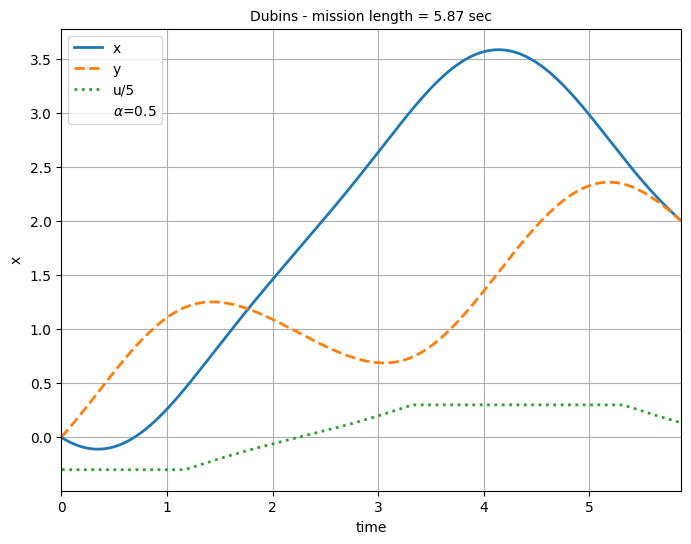

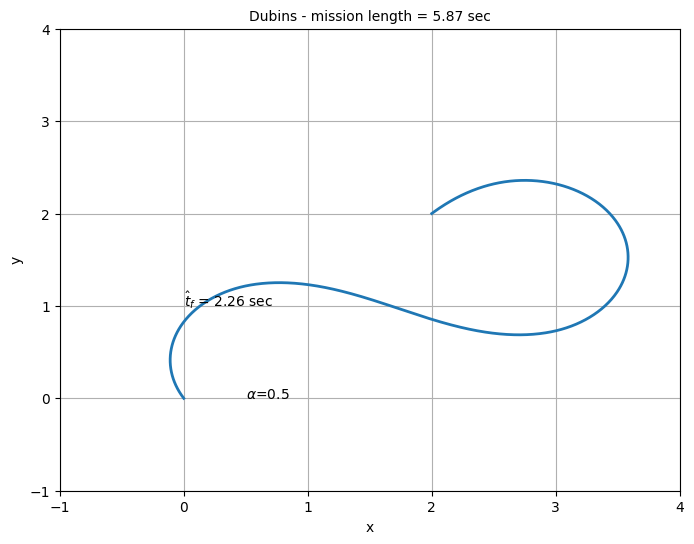

In [6]:
print('mission length = ' + str(round(m.tf(),3)) + ' seconds')

# access the results
t = np.array([t*m.tf() for t in m.t])
x = np.array([m.x[t]() for t in m.t])
y = np.array([m.y[t]() for t in m.t])
theta = np.array([m.th[t]() for t in m.t])
u = np.array([m.u[t]() for t in m.t])

plt.figure(3,figsize=(8,6))
plt.plot(t, x, ls='-')
plt.plot(t, y, ls='--')
plt.plot(t[1:-1], u[1:-1]/5, ls=':')
plt.plot(np.NaN, np.NaN, '-', color='none')
plt.xlabel('time')
plt.xlim([0, m.tf()])
plt.ylabel('x')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.legend(['x','y','u/5',r'$\alpha$='+ str(round(alp,2))])
plt.grid(True)

plt.figure(4,figsize=(8,6))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.text(0,Y1/2,r'$\hat t_{f}$ = '+ str(round(tf_estimate,2))+ ' sec')
plt.text(0.5,0,r'$\alpha$='+ str(round(alp,2)))
plt.xlim([-1, 4])
plt.ylim([-1, 4])
plt.grid(True)